# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: 自分自身で考えさせて､正解のデータを学習させる

In [3]:
%reload_ext autoreload
%autoreload 2

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm


In [4]:
#dataset settings
n_test=50 #number of testing data
n_train_check=50 #number of training data for checking (i.e., checking everything takes too long, so we check only a part of training data)
n_GPT_reasoning=30 # number of reasoning data made by GPT

#model settings
model_name="mistralai/Mixtral-8x7B-Instruct-v0.1"
target_modules= [
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate",
    "w1",
    "w2",
    "w3"
]

model_name=f"meta-llama/Llama-2-7b-chat-hf"
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]



#LoRA settings
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#train settings
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5

#device settings
device_map="auto"

#dataset path
dataset_path="dataset/231225AutoReasoning/240117best_reason_record_30k.csv"

In [5]:
#init model
from llmchem.model import init_model
#model=init_model(model_name, r, lora_alpha, target_modules, bit=bit,device_map=device_map)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Prepare dataset

In [7]:
import pandas as pd
import random
df=pd.read_csv(dataset_path)
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

train_dataset=dataset[:-n_test]
example_reasoning_dataset=train_dataset[:n_GPT_reasoning]
test_dataset=dataset[-n_test:]

# モデル自身によるデータセットの生成

In [ ]:
from datetime import datetime
import json
from llmchem.utils import clean_vram
from llmchem.inference import ask_value, generate_question_prompt

#prompt tuningをランダムに変えながら､訓練データで予測(自習)していく

#予測時のハイパラ
n_max_trials=4  # 値を返さなかったときの再試行の最大数
error_threshold=30 #結果を保存する許容誤差
prediction_results={}

res_list=[]

for train_id in tqdm(range(10**5)):
    #clear_output()
    clean_vram()
    for _ in range(n_max_trials):
        try:
        #if True:

            n_prompt_examples=random.randint(1,5) #number of prompt tuning
            prompt=generate_question_prompt(dataset,train_id,
                                            n_prompt_examples=n_prompt_examples,
                                            prompt_dataset=example_reasoning_dataset)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue

        if len(reason)<30:
            continue

        if value is not None:
            try:
                value=float(value)
            except:
                continue

            record=copy.deepcopy(dataset[train_id])
            record["Reason"]=reason
            record["Prediction(integer)"]=value
            record["model_name"]=model_name

            err=abs(record["mpC"]-float(value))
            print("actual: ",record["mpC"],"predicted: ", value,"err: ",err)
            print(reason)

            
            if err<error_threshold:
                current_datetime = datetime.now()

                save_path=f"dataset/240116mixtral_reasoning/{current_datetime}.json"
                save_path=f"dataset/240116llama2_reasoning/{current_datetime}.json"
                save_path.replace("-","").replace(":","")
                with open(save_path,"w") as f:
                    json.dump(record,f,indent=4)

                break

# モデルの訓練

In [17]:
import transformers
from datetime import datetime


def gen_train_text(dataset):
    train_text_list=[]
    for id in range(len(dataset)):
        prompt=gen_compound_text(dataset[id],
                                    reason=dataset[id]["Reason"],
                                    prediction=dataset[id]["Prediction(integer)"])
        train_text_list.append(prompt)

    return train_text_list


#tokenized_dataset = prepare_dataset(gen_train_text(example_prompt_list), tokenizer)
tokenized_dataset = prepare_dataset(gen_train_text(dataset)[n_test:], tokenizer)

#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

Map: 100%|██████████| 2356/2356 [00:00<00:00, 7871.98 examples/s]
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.239300
200,1.023600
300,0.982400
400,0.933600
500,0.949500
600,0.918200
700,0.894300
800,0.923400
900,0.907700
1000,0.894100


In [18]:


#モデルの保存: adapterのみ保存するとき｡
#from datetime import datetime
#current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
model.save_pretrained(f"./outputs/mixtral_3epoch_0117")

#モデルの読み込み: afapter経由で読み込むとき
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"
#model_path="./outputs/7b_ft_with_self_prediction_0115"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )
"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n'

# モデル性能の評価

In [19]:
model.eval()

#予測時のハイパラ
n_prompt_examples=0 #何件の例題をprompt tuningで出すか:  例題に予測が引っ張られがちなので､0にしてみる
n_max_trials=1  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            res_list.append(record)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [01:18<1:04:06, 78.50s/it]

----


The compound (1,2,2,3-tetramethylcyclopentyl)methyl 4-aminobenzoate has several functional groups that influence its melting point. The base structure is a cyclopentane ring, which has a melting point of around -94°C. The addition of four methyl groups increases the molecular weight and steric hindrance, which typically raises the melting point. Each methyl group can be estimated to increase the melting point by about 20°C. The benzoyl group is a large, rigid structure that significantly increases the melting point due to increased molecular weight and potential for π-π interactions; this could be estimated to raise the melting point by about 80°C. The amino group can form hydrogen bonds, which would further increase the melting point, estimated at about 40°C. The ester linkage (methyl 4-aminobenzoate) adds polarity and potential for dipole-dipole interactions, which could raise the melting point by about 30°C. Adding these increments to the base value of cyclopentane gives the 

  4%|▍         | 2/50 [02:16<53:20, 66.68s/it]  

----


- Basic unit, quinoxaline has a melting point of around 20°C. 
- Chloro substituents: Each chloro group is electron-withdrawing and increases intermolecular forces such as dipole-dipole interactions, which typically raises the melting point. The effect of each chloro group can be estimated to increase the melting point by about 20°C. 
- Steric hindrance: The ortho positioning of the chloro groups to each other may cause some steric hindrance, which could slightly lower the melting point. This effect might be around -5°C for each chloro group. 
- Overall, the electron-withdrawing effect of the chloro groups is expected to have a greater impact than the steric hindrance, leading to an overall increase in the melting point.
##Prediction: 65.0
##Confidence: 70.0
##Comment: The prediction is close to the actual value, indicating a good understanding of the effects of the substituents on the melting point. However, the steric hindrance effect might be overestimated, leading to a sligh

  6%|▌         | 3/50 [03:45<1:00:04, 76.69s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The introduction of chloromethyl groups to the benzene ring increases the melting point due to the following reasons: 
- Chloromethyl groups: Each chloromethyl group increases the molecular weight and the polarity of the molecule, which leads to stronger intermolecular forces such as dipole-dipole interactions. This typically raises the melting point. 
- Steric hindrance: The presence of two chloromethyl groups in the ortho position to each other may cause steric hindrance, which can disrupt the crystal lattice and lower the melting point. However, since the actual value is known to be 67.0°C, the effect of steric hindrance is not significant enough to lower the melting point substantially. 
- Polarity: The chlorine atoms in the chloromethyl groups increase the polarity of the molecule, which can lead to stronger intermolecular forces and a higher melting point. 
Considering these factors, the addition of each chloromethyl g

  8%|▊         | 4/50 [05:04<59:21, 77.42s/it]  

----


The compound (2E)-1,3-Diphenyl-2-propen-1-one, also known as chalcone, is a molecule with several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The presence of two phenyl groups increases the melting point due to the increased molecular weight and the pi-pi stacking interactions between the rings, which provide additional stability to the crystal lattice. Each phenyl group can be estimated to raise the melting point by approximately 40°C. The alpha, beta-unsaturated carbonyl group (propenone) also contributes to the melting point through polar interactions and possible hydrogen bonding with other molecules. This group can be estimated to raise the melting point by about 20°C. Therefore, the combined effect of two phenyl groups and one propenone group is added to the base melting point of benzene.
##Prediction: 105.0
##Confidence: 80.0
##Reference: Prediction based on the known effects of functional g

 10%|█         | 5/50 [06:33<1:01:27, 81.94s/it]

----


- Basic unit, ethane has a melting point of -172.0 degrees Celsius. 
- Hydroxyl group (OH): +100.0 (due to hydrogen bonding capabilities, which significantly increases the melting point). 
- Disulfide bond (SS): +20.0 (due to the presence of sulfur, which increases the molecular weight and provides some rigidity to the molecule, but not as much as hydrogen bonding). 
- Ethylene glycol-like structure (OCC): +10.0 (due to the presence of two oxygen atoms which can engage in dipole-dipole interactions, slightly increasing the melting point). 
- The combined effect of these functional groups leads to a significant increase in the melting point from the base value of ethane.
##Prediction: -42.0
##Confidence: 80%
##Reference: Prediction based on the known effects of functional groups on melting points.
##Category: Small molecules
##URL: https://pubchem.ncbi.nlm.nih.gov/compound/2-Hydroxyethyl_disulfide
##Properties:
##Melting point: -42.0
##Predicted by: system

##Justification
The pr

 12%|█▏        | 6/50 [07:50<58:46, 80.15s/it]  

----


- Basic unit, nicotinamide has a melting point of 129°C. 
- Phenyl groups: Each phenyl group increases the melting point due to increased molecular weight and pi-pi interactions. Estimated effect per phenyl group: +20°C. 
- Ethyl group: Slight increase in molecular weight and van der Waals forces. Estimated effect: +5°C. 
- Amino group: Hydrogen bonding can increase the melting point. Estimated effect: +10°C. 
- Conjugation with aromatic rings: Can increase the melting point due to increased rigidity and planarity. Estimated effect: +5°C. 
- Overall, the compound has two phenyl groups, one ethyl group, and one amino group attached to the nicotinamide base. The conjugation effect is considered to be part of the aromatic ring's contribution. 
- The predicted melting point is the sum of the effects of these functional groups added to the base melting point of nicotinamide.
##Prediction: 189.0
##Confidence: 80%
##Reference: Prediction based on the effects of functional groups on the

 14%|█▍        | 7/50 [08:58<54:39, 76.28s/it]

----


- Basic unit, benzophenone has a melting point of 48.5°C. 
- Methoxy groups: There are two methoxy groups attached to the benzene rings. Each methoxy group is electron-donating and can participate in resonance, which stabilizes the crystal lattice, thus increasing the melting point. However, the presence of the methoxy groups also increases the molecular weight and size, which can disrupt the crystal packing, potentially lowering the melting point. The net effect of each methoxy group is estimated to be -5°C. 
- Methyl group: The 4-methylphenyl group adds steric bulk, which can disrupt the crystal packing, potentially lowering the melting point. The effect of the methyl group is estimated to be -10°C. 
- Combining these effects, the overall predicted change in melting point is -15°C (2 methoxy groups * -5°C each + 1 methyl group * -10°C).
##Prediction: 33.0
##Confidence: 50.0
##Reference: Prediction based on the effects of functional groups on the melting point of benzophenone.


 16%|█▌        | 8/50 [10:27<56:12, 80.29s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Propyl group: The propyl group is an alkyl chain that tends to lower the melting point due to increased molecular size and decreased symmetry, which can disrupt the crystal lattice of the compound. The effect of a propyl group can be estimated to lower the melting point by approximately -40°C.
##Prediction: -34.5
##Confidence: 80.0
##Reference: Prediction based on the known effects of alkyl groups on the melting point of benzene derivatives.
##Data: {}
##Tags:
##History:
##Description: The prediction for the melting point of propylbenzene is based on the known effects of alkyl groups on the melting point of benzene derivatives. The basic unit, benzene, has a melting point of 5.5°C. The propyl group, being an alkyl chain, tends to lower the melting point due to increased molecular size and decreased symmetry, which can disrupt the crystal lattice of the compound. The effect of a propyl group can be estimated to lower the melt

 18%|█▊        | 9/50 [11:39<52:54, 77.44s/it]

----


- Basic unit, acetamide has a melting point of around 82°C. 
- Phenyl group: +20°C (due to increased molecular weight and pi-pi interactions). 
- Nitro group: +30°C (due to strong electron-withdrawing nature, which increases intermolecular forces such as hydrogen bonding). 
- The amide linkage to the phenyl ring adds rigidity to the molecule, which can increase the melting point. However, since this is part of the basic unit (acetamide), it's not counted separately. 
- The overall structure is planar and can stack well in the solid state, which typically increases the melting point. 
- The presence of both electron-donating (amide NH) and electron-withdrawing (nitro) groups on the aromatic ring can lead to a balance of intermolecular forces, which might not significantly alter the melting point from the predicted value.
##Prediction: 132.0
##Confidence: 80.0
##Reference: Prediction based on known effects of functional groups on melting point.
##Data: {'Basic unit': 82.0, 'Phenyl

 20%|██        | 10/50 [12:20<44:13, 66.34s/it]

----


- Basic unit, ethyl acetate has a melting point of -83.6°C. 
- Propyl group: +1°C (larger alkyl chain increases the molecular weight and surface area, leading to a slight increase in the melting point). 
- Acetyl group: -1°C (the acetyl group is already accounted for in the basic unit, ethyl acetate). 
- N-substitution: +1°C (the N-substitution adds steric bulk, which can slightly increase the melting point). 
- Overall, the effects of the propyl group and N-substitution are relatively small and in the same direction, so their combined effect is estimated to be +2°C.
##Prediction: -81.0
##Confidence: 70%
##Prediction
actual:  -92.0 predicted:  -81.0
promlem 11 / 50


 22%|██▏       | 11/50 [13:30<43:53, 67.52s/it]

----


- Basic unit, anisole has a melting point of -37.5°C. 
- Iodo substituent: +80 (due to the significant increase in molecular weight and size, as well as the inductive effect which stabilizes the crystal lattice) 
- Nitro group: +40 (due to the strong electron-withdrawing nature of the nitro group, which increases intermolecular forces such as dipole-dipole interactions) 
- Methoxy group: -5 (due to the electron-donating effect which slightly lowers the melting point compared to a hydrogen atom) 
- Ortho effect of nitro group: -5 (steric hindrance can disrupt crystal packing, slightly lowering the melting point) 
- Iodo substituent in ortho position to methoxy: -5 (steric hindrance between the iodo and methoxy groups can further disrupt crystal packing) 
- Overall, the strong electron-withdrawing effects of the nitro group and the iodo substituent are the main contributors to the increase in melting point.
##Prediction: 77.0
##Confidence: 80
##Reference: Prediction based on the a

 24%|██▍       | 12/50 [14:58<46:45, 73.84s/it]

----


- Basic unit, ethene has a melting point of -169.2°C. 
- Addition of each methyl group: +20°C (due to increased molecular weight and van der Waals forces). 
- Addition of each double bond: +10°C (due to increased rigidity of the molecule). 
- Addition of two methyl groups: 2 * +20°C = +40°C. 
- Addition of one double bond: +10°C. 
- The presence of the double bond in a cis (Z) configuration adds some rigidity to the molecule, which might slightly increase the melting point compared to a trans (E) configuration. However, this effect is relatively minor and can be estimated at around +2°C. 
- Therefore, the combined effect of the two methyl groups and the double bond is +52°C. 
- However, the actual value of the melting point is -139.0°C, which is significantly lower than the predicted value. This discrepancy suggests that the effects of the functional groups on the melting point are overestimated. The presence of the double bond and the methyl groups likely do not increase the me

 26%|██▌       | 13/50 [15:50<41:24, 67.14s/it]

----


The compound in question is a hydrazone derivative with a bicyclic structure and two nitro groups. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The bicyclic structure introduces significant rigidity to the molecule, which typically increases the melting point due to the restricted rotation around bonds and the overall more ordered structure. This rigidity might contribute an estimated +100°C to the melting point. The hydrazone linkage (NN=C) is a site for hydrogen bonding, which can further increase the melting point; this could be estimated as +20°C. Each nitro group is electron-withdrawing and can participate in intermolecular interactions, such as dipole-dipole interactions, which can also increase the melting point. The effect of each nitro group might be around +30°C. Therefore, the overall predicted increase in melting point due to the functional groups would be approximately +180°C.
##Prediction: 185.0
##Prediction
actual:  203.0 predicte

 28%|██▊       | 14/50 [17:22<44:48, 74.67s/it]

----


- Basic unit, indole: estimated melting point of 52°C. 
- Acetyl group: +40°C (due to increased molecular weight and potential for hydrogen bonding). 
- Nitro group: +80°C (due to strong electron-withdrawing nature and potential for intermolecular interactions). 
- Phenyl group: +30°C (due to increased molecular weight and π-π interactions). 
- Ethyl carbonate group: +50°C (due to the polar nature of the ester and the ability to form dipole-dipole interactions). 
- The cumulative effect of these functional groups is additive, but the actual value of the melting point is given as 175.0°C, which suggests that the initial estimates for each group's contribution need to be adjusted to match the actual value.
##Prediction: 175.0
##Confidence: 90.0
##Reference: Prediction based on the known effects of functional groups on the melting point of a compound. The values for each group's contribution are estimated based on typical values for similar functional groups in other compounds.
##C

 30%|███       | 15/50 [18:48<45:34, 78.11s/it]

----


- Basic unit, octane has a melting point of -57 degrees Celsius. 
- Methyl groups: Each methyl group tends to increase the melting point due to an increase in molecular weight and van der Waals forces. However, the effect is not as strong as in larger alkanes. For octane, adding two methyl groups might increase the melting point by approximately 2 degrees Celsius for each group. 
- Position of methyl groups: The position of the methyl groups can influence the melting point. In this case, the 2,7-dimethyl configuration may lead to a more compact structure, which could slightly increase the melting point compared to a straight-chain alkane. However, the effect is not significant enough to change the prediction drastically. 
- Prediction: -57 (octane) + 2 (first methyl group) + 2 (second methyl group) = -53 degrees Celsius.
##Prediction: -53.0
##Confidence: 80.0
##Reference: https://webbook.nist.gov/cgi/cbook.cgi?ID=C104345&Units=C&Mask=200#Thermo-Properties
##Comment: The predicti

 32%|███▏      | 16/50 [19:30<38:00, 67.06s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Phenoxy group: +30 (introduces dipole-dipole interactions and potential hydrogen bonding, increasing the melting point) 
- Aldehyde group: +20 (polar carbonyl group increases the melting point due to dipole-dipole interactions) 
- Additional phenyl ring: +15 (increases molecular weight and rigidity, leading to higher melting point) 
- Overall molecular symmetry and planarity: +5 (contributes to efficient packing in the solid state, increasing the melting point) 
- The combined effects of these functional groups lead to an increase in the melting point relative to benzene.
##Prediction: 75.0
##Confidence: 80%
##Prediction
actual:  25.0 predicted:  75.0
promlem 17 / 50


 34%|███▍      | 17/50 [21:01<40:50, 74.27s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The molecule contains several functional groups and structural features that will affect the melting point: 
- Benzofuran rings: These are aromatic heterocycles that generally increase the melting point due to their rigid structure and potential for π-π stacking interactions. We can estimate an increase of about +40°C for each benzofuran ring. 
- Chloro substituent: Halogens like chlorine can increase the melting point due to their electronegativity and the potential for intermolecular interactions. We can estimate an increase of about +20°C for the chloro group. 
- Methyl group: Alkyl groups like methyl can increase the melting point due to an increase in molecular weight and van der Waals forces. We can estimate an increase of about +5°C for the methyl group. 
- Butanone moiety: The presen

 36%|███▌      | 18/50 [22:28<41:44, 78.26s/it]

----


The basic unit for 1,2-propadiene is ethylene, which has a melting point of -169.2°C. The addition of one more carbon in 1,2-propadiene to form a triple bond (acetylene) typically increases the melting point due to increased linearity and stronger intermolecular forces from the triple bond. However, the effect of the triple bond is not as significant as the effect of the double bond in ethylene due to the linear geometry of the triple bond which allows for better packing, but the overall molecular size is still small. The increase in melting point due to the triple bond is estimated to be around +10°C.
##Prediction: -159.0
##Confidence: 70.0
##Reference: Prediction based on the known melting point of ethylene and the estimated effect of the triple bond.
##Data: {'Name': '1,2-propadiene', 'Prediction': -159.0, 'Confidence': 70.0}
##SampleId: 10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

 38%|███▊      | 19/50 [23:19<36:13, 70.11s/it]

----


- Basic unit, furan has a melting point of -85.6°C. 
- Aldehyde group: +40°C (introduces polarity and potential for hydrogen bonding, significantly increasing the melting point). 
- Bromine substituent: +20°C (increases molecular weight and van der Waals forces, raising the melting point). 
- The presence of the bromine atom also contributes to the rigidity of the molecule, which can further increase the melting point. 
- The combined effects of the aldehyde and bromine functional groups are additive. 
##Prediction: 34.0
##Confidence: 80.0
##Reference: Prediction based on the effects of functional groups on the melting point of furan.
##Data: {'Basic unit (furan)': -85.6, 'Aldehyde group': 40.0, 'Bromine substituent': 20.0}
##Prediction
actual:  56.0 predicted:  34.0
promlem 20 / 50


 40%|████      | 20/50 [24:13<32:35, 65.18s/it]

----


- Basic unit, pyridine has a melting point of -42°C. 
- Fluorine substituents: Each fluorine is electron-withdrawing and increases intermolecular forces due to its high electronegativity, which typically raises the melting point. Let's estimate an increase of +20°C per fluorine atom. 
- Amino group: The amino group can form hydrogen bonds, which significantly increases the melting point. We can estimate an increase of +80°C for the amino group. 
- Steric hindrance and electronic effects of the substituents on the ring may also affect the melting point, but these are more difficult to quantify without empirical data. 
- Considering these effects, the overall increase would be the sum of the individual contributions.
##Prediction: 108.0
##Confidence: 70.0
##Comment: The prediction is close to the actual value, indicating that the estimated contributions of the functional groups are in the right direction but may not be perfectly accurate.
##Prediction
actual:  86.0 predicted:  108

 42%|████▏     | 21/50 [25:43<35:04, 72.56s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Methyl groups: There are two methyl groups attached to the benzene rings. Each methyl group can increase the melting point due to an increase in molecular weight and van der Waals forces. However, the effect is not as strong as it might be in other molecules because the methyl groups are not in a position to significantly enhance the crystal packing efficiency. Estimated effect of each methyl group is +5°C. 
- Hydroxyl group: The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. However, in this molecule, the hydroxyl group is not in a position to form strong intermolecular hydrogen bonds due to steric hindrance from the adjacent methyl groups. The effect of the hydroxyl group is therefore less than it would be in a molecule without steric hindrance. Estimated effect is +10°C. 
- Steric hindrance from the methyl groups adjacent to the hydroxyl group will slightly reduce the effectivenes

 44%|████▍     | 22/50 [26:26<29:41, 63.64s/it]

----


- Basic unit, thiadiazine ring: estimated melting point of 100°C due to the presence of nitrogen and sulfur atoms which contribute to ring stability and potential for hydrogen bonding. 
- Phenyl group: +20°C, due to increased molecular weight and pi-pi interactions. 
- Isopropyl group: +5°C, due to increased molecular weight and van der Waals interactions. 
- Triazole ring: +15°C, due to the presence of nitrogen atoms which can engage in hydrogen bonding and dipole-dipole interactions. 
- Overall, the compound has multiple rings and functional groups that can engage in various intermolecular forces, leading to a higher melting point.
##Prediction: 140.0
##Confidence: 80%
##Prediction
actual:  226.0 predicted:  140.0
promlem 23 / 50


 46%|████▌     | 23/50 [27:54<31:59, 71.10s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Hydroxyl group: +80 (due to hydrogen bonding capabilities, which significantly increases the melting point). 
- Carboxylic acid group: +70 (due to strong hydrogen bonding and dimerization in the solid state, which greatly increases the melting point). 
- Chlorine substituent: +20 (due to increased molecular weight and polarity, which can lead to higher melting points). 
- The ortho-positioning of the hydroxyl and carboxyl groups to each other on the benzene ring would lead to additional intermolecular hydrogen bonding, which could further increase the melting point. However, since the exact quantitative effect of this intramolecular interaction is not easily predictable without empirical data, it will not be added as a separate incremental value.
##Prediction: 175.0
##Confidence: 80%
##Reference: Prediction based on the additive effects of functional groups on the melting point of benzene.
##Category: Carboxylic acids and de

 48%|████▊     | 24/50 [29:23<33:04, 76.31s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Chloro substituent: +40°C (due to increased molecular weight and polarity). 
- Hydrazono group: +30°C (due to the potential for hydrogen bonding and increased molecular rigidity). 
- Nitrile group: +20°C (due to the strong dipole and linear geometry which can lead to increased intermolecular interactions). 
- Thiazole ring: +25°C (due to the heteroatoms which can engage in additional dipole-dipole interactions and potential hydrogen bonding). 
- Methyl group on the phenyl ring: +5°C (due to increased molecular weight and van der Waals interactions). 
- The conjugation and planarity of the molecule can lead to better packing in the solid state, which generally increases the melting point. However, this effect is not quantified here but is considered in the overall structural rigidity and intermolecular interactions. 
- The combined effect of these functional groups leads to a significant increase in the melting point compared

 50%|█████     | 25/50 [30:35<31:16, 75.05s/it]

----


The basic unit for flavone can be considered as benzene, which has a melting point of 5.5°C. The presence of two phenyl rings in flavone contributes to an increase in melting point due to the larger molecular size and increased van der Waals forces. Each phenyl ring can be estimated to add approximately +20°C. The carbonyl group (C=O) introduces polarity and the potential for hydrogen bonding, which can significantly raise the melting point. The carbonyl group can be estimated to add around +40°C. However, the actual value of the melting point is 98.0°C, which suggests that the individual contributions of the phenyl rings and the carbonyl group have been overestimated. Adjusting the contributions to match the actual value, the phenyl rings might contribute less than +20°C each, and the carbonyl group might contribute less than +40°C. A more accurate estimation would be to consider the phenyl rings to add around +15°C each and the carbonyl group to add around +30°C.
##Prediction:

 52%|█████▏    | 26/50 [31:28<27:25, 68.57s/it]

----


- Basic unit, indole has a melting point of around 52°C. 
- Carboxylic acid group: +100 (due to strong hydrogen bonding and dimerization, which significantly increases the melting point). 
- Tetrahydro structure (addition of four hydrogens): +20 (introduction of hydrogen atoms generally increases the melting point due to increased molecular weight and van der Waals forces). 
- Beta-carboline structure (additional ring fusion): +30 (ring fusion generally increases the melting point due to increased rigidity and planarity of the molecule, which enhances stacking and packing in the solid state). 
- The overall structure is relatively rigid and planar, which can lead to strong intermolecular interactions and a higher melting point. 
- Considering these effects cumulatively, the predicted melting point is calculated by adding the contributions of each functional group to the base value of indole.
##Prediction: 202.0
##Confidence: 80%
##Prediction
actual:  296.0 predicted:  202.0
prom

 54%|█████▍    | 27/50 [32:25<24:58, 65.15s/it]

----


- Basic unit, pyrazole has a melting point of around 70°C. 
- Methanol group: +20°C (due to the presence of a hydroxyl group, which can form hydrogen bonds, increasing the melting point). 
- Methyl group: +5°C (small alkyl groups like methyl can increase the melting point due to increased molecular weight and van der Waals interactions). 
- The presence of the methyl group also slightly increases the symmetry of the molecule, which can lead to a more ordered crystal lattice and a higher melting point. 
- However, the overall molecule is still relatively small, which limits the potential for a very high melting point. 
- The combined effects of the functional groups should lead to an increase in the melting point from the base value of pyrazole.
##Prediction: 95.0
##Confidence: 80%
##Reference: Prediction based on known effects of functional groups on melting point and the base value for pyrazole.
##Category: Melting point
##URL: https://en.wikipedia.org/wiki/Pyrazole

##Predicti

 56%|█████▌    | 28/50 [33:55<26:34, 72.48s/it]

----


- Basic unit, cyclohexanone has a melting point of 47°C. 
- Addition of a methyl group typically raises the melting point due to increased molecular weight and van der Waals forces. 
- However, the presence of the bicyclic structure and the additional methyl groups in 1,8,8-trimethylbicyclo[3.2.1]octan-2-one creates a more rigid and compact structure, which can lead to a higher melting point. 
- The three methyl groups are not all equivalent in their effect on the melting point. The one on the ketone (C2) may have a larger effect due to steric hindrance and the introduction of a chiral center, which can increase the melting point significantly. 
- The other two methyl groups (C1 and C3) are likely to have a smaller effect as they are not directly adjacent to the ketone and do not introduce additional chiral centers. 
- Estimating the effects quantitatively: Ketone methyl group: +20°C, other two methyl groups: +5°C each. 
- Therefore, the predicted melting point is the sum of the

 58%|█████▊    | 29/50 [34:50<23:30, 67.19s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Naphthalene, which is two fused benzene rings, has a melting point of 80.2°C, indicating that the fused ring structure significantly increases the melting point due to increased molecular rigidity and pi-pi interactions. 
- Bromomethyl group: -20°C (introduction of a polar substituent can disrupt the crystal lattice, leading to a decrease in melting point). 
- The naphthalene base has a much higher melting point than benzene, and the bromomethyl group's effect is relatively minor in comparison. Therefore, the melting point will be closer to that of naphthalene with a slight decrease due to the bromomethyl group.
##Prediction: 60.0
##Confidence: 70.0
##Reference: Prediction based on known melting points of similar compounds and the effects of functional groups on melting points.
##SMILES: BrCc1ccc2ccccc2c1
##Reason
actual:  56.0 predicted:  60.0
promlem 30 / 50


 60%|██████    | 30/50 [36:23<24:56, 74.83s/it]

----


The target compound is a complex molecule with several functional groups that influence its melting point. The basic unit we can consider is benzophenone, which has a melting point of around 48°C. The compound in question has two benzophenone units, which would suggest an increase in melting point due to the larger molecular weight and potential for additional intermolecular interactions. However, the presence of the 1,7,7-trimethylbicyclo[2.2.1]heptane moiety introduces steric hindrance and reduces the overall symmetry of the molecule, which could lower the melting point. The nitrile groups are polar and can engage in dipole-dipole interactions, potentially increasing the melting point. However, the overall effect of these groups is complex and not simply additive. The presence of the bulky bicyclic structure and the nitrile groups likely leads to a decrease in the melting point from the base benzophenone value.
##Prediction: 105.0
##Confidence: 50.0
##Comment: The prediction i

 62%|██████▏   | 31/50 [37:55<25:21, 80.06s/it]

----


The target compound is a complex molecule with multiple aromatic rings and amide linkages. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The presence of multiple aromatic rings in the biphenyl structure significantly increases the melting point due to increased pi-pi interactions and van der Waals forces. Each additional aromatic ring can be estimated to increase the melting point by approximately 20°C. The tetrabenzamide structure introduces four amide linkages, which can form strong intermolecular hydrogen bonds, significantly raising the melting point. Each amide group can be estimated to increase the melting point by about 40°C due to the potential for extensive hydrogen bonding. Therefore, the combined effect of the additional aromatic rings and amide linkages must be considered.
##Prediction: 245.0
##Confidence: 80%
##Comment: The prediction is based on the additive effects of multiple aromatic rings and amide linkages on the melting point 

 64%|██████▍   | 32/50 [39:01<22:48, 76.00s/it]

----


- Basic unit, isoxazole has a melting point of around 80°C. 
- Methyl groups: Each methyl group typically raises the melting point due to an increase in molecular weight and van der Waals forces. For isoxazole, each methyl group might add approximately +5°C. 
- Boronic acid group: This group is capable of forming strong intermolecular hydrogen bonds, which significantly increases the melting point. The boronic acid group could add around +100°C to the melting point of the base structure. 
- Overall, the presence of two methyl groups and a boronic acid group would lead to an increase in the melting point.
##Prediction: 190.0
##Confidence: 80.0
##Comment: The prediction is based on the effects of functional groups on the melting point of the base structure, isoxazole. The addition of two methyl groups and a boronic acid group is expected to significantly increase the melting point from the base value.
##Reference: Prediction based on known effects of functional groups on melting p

 66%|██████▌   | 33/50 [40:34<22:54, 80.87s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Hydroxyl group: +80°C (strong hydrogen bonding increases the melting point significantly). 
- Hydrazone group: +50°C (introduces rigidity and potential for hydrogen bonding). 
- Nitrile group: +40°C (polar group increases intermolecular forces). 
- Thiazole ring: +30°C (heterocyclic compound with nitrogen and sulfur, which increases the melting point due to stronger intermolecular forces). 
- Methyl group on phenyl: +10°C (increases molecular weight and van der Waals forces slightly). 
- Additional phenyl group: +20°C (increases molecular weight and rigidity of the molecule). 
- Conjugation and planarity of the molecule: +10°C (increases intermolecular interactions due to better packing). 
- Extended conjugation and potential for π-π stacking: +15°C (additional stabilization from aromatic interactions). 
- Overall molecular complexity and potential for multiple intermolecular interactions: +20°C (larger and more complex mole

 68%|██████▊   | 34/50 [42:02<22:12, 83.25s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Carboxylic acid group: +100°C (due to strong hydrogen bonding and dimerization). 
- Naphtyl group: +20°C (due to increased molecular weight and van der Waals interactions). 
- Methyl group: +5°C (due to a slight increase in molecular weight and van der Waals interactions). 
- Methoxy group: -5°C (due to the electron-donating effect which can slightly lower the melting point). 
- Stereochemistry (DL- form): +0°C (stereochemistry does not significantly affect the melting point in this case). 
- Overall, the presence of the carboxylic acid group has the most significant impact on the melting point due to its ability to form strong intermolecular hydrogen bonds, which greatly increases the melting point.
##Prediction: 125.0
##Confidence: 80.0
##Reference: Prediction based on the known effects of functional groups on the melting point of benzene derivatives and the actual value of 155°C for DL-Naproxen.
##Justification: The predi

 70%|███████   | 35/50 [43:29<21:04, 84.27s/it]

----


- Basic unit, phenol has a melting point of 41°C. 
- Chloro substituent: +20 (due to increased molecular weight and polarity, which enhances intermolecular forces). 
- Ethoxy substituent: -10 (due to the ether linkage which can reduce the overall polarity compared to a hydroxyl group, slightly decreasing the melting point). 
- Ortho effect (steric hindrance): +5 (the ortho substituents can cause some steric hindrance, which might slightly increase the melting point due to a more rigid structure). 
- Overall, the chloro substituent's effect is stronger than the ethoxy group's effect, leading to a net increase in the melting point.
##Prediction: 56.0
##Confidence: 80.0
##Reference: Prediction based on the known effects of substituents on the melting point of benzene derivatives. The actual value of 56°C is used as a reference to adjust the prediction.
##Justification: The prediction of 56.0°C is based on the sum of the effects of the substituents on the basic unit of phenol. The c

 72%|███████▏  | 36/50 [44:58<19:59, 85.68s/it]

----


- Basic unit, acetic acid has a melting point of 16.6°C. 
- Methyl groups: Each methyl group increases the molecular weight and provides more van der Waals forces, which typically raises the melting point. However, the increase is not linear and the effect of each additional methyl group is less than the previous one due to steric hindrance and branching. The first methyl group might increase the melting point by approximately +20°C, while the second and third might add around +15°C each. 
- Carboxylic acid group: The presence of the carboxylic acid group contributes to strong intermolecular hydrogen bonding, which significantly raises the melting point. However, since this is the base structure, it is already accounted for in the melting point of acetic acid. 
- Branching: The branching in the molecule due to the three methyl groups can lower the melting point due to less efficient packing in the solid state. This effect might be around -5°C. 
Combining these effects, the predi

 74%|███████▍  | 37/50 [46:38<19:28, 89.87s/it]

----


The target compound is a complex molecule with multiple functional groups that influence its melting point. The basic structure is a polycyclic system, which typically has a high melting point due to the rigid structure and strong intermolecular forces. Each functional group will either increase or decrease the melting point based on its properties. Here are the considerations for each functional group: 
- Polycyclic system: +100 (due to rigidity and strong intermolecular forces) 
- Acetoxy groups (2x): +20 each (ester groups increase polarity and potential for hydrogen bonding) 
- Benzoyl group: +30 (aromatic ring increases molecular weight and rigidity) 
- Benzoate group: +20 (aromatic ester increases polarity and potential for hydrogen bonding) 
- Hydroxy groups (3x): +10 each (hydrogen bonding capability) 
- Keto groups (2x): +20 each (polar carbonyl groups increase intermolecular forces) 
- Epoxy group: +10 (adds ring strain and polarity) 
- Amino group: +10 (potential for 

 76%|███████▌  | 38/50 [47:15<14:49, 74.09s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. Dibenz[ah]anthracene is a polycyclic aromatic hydrocarbon (PAH) with four fused benzene rings. Each additional fused ring increases the rigidity and planarity of the molecule, which generally leads to higher melting points due to increased pi-pi stacking interactions and van der Waals forces. The presence of four fused rings in dibenz[ah]anthracene is expected to significantly increase the melting point compared to benzene. The increase per fused ring can be estimated to be around +40°C.
##Prediction: 165.0
##Confidence: 80.0
##Prediction
actual:  269.0 predicted:  165.0
promlem 39 / 50


 78%|███████▊  | 39/50 [48:42<14:19, 78.12s/it]

----


The target compound is a tris-substituted benzene with three phenyl rings connected by a central ethenylidene (vinylidene) group. The basic unit, benzene, has a melting point of 5.5°C. Each additional phenyl ring increases the molecular weight and the surface area, which typically increases the melting point due to greater London dispersion forces. However, the presence of the ethenylidene group introduces rigidity and planarity to the molecule, which can lead to stronger intermolecular interactions such as π-π stacking between the aromatic rings. This rigidity and planarity can increase the melting point significantly. The effect of each phenyl ring can be estimated to add approximately +20°C to the melting point due to increased molecular weight and surface area. The ethenylidene group's effect is more complex, but it can be estimated to add around +40°C due to the rigidity and planarity it introduces. Therefore, the total estimated increase would be 3 phenyl rings * +20°C eac

 80%|████████  | 40/50 [50:13<13:39, 81.98s/it]

----


The target compound is a complex molecule with several functional groups that influence its melting point. The basic unit we can consider is acetamide, which has a melting point of around 82°C. The functional groups present in the target compound and their estimated effects on the melting point are as follows: 
- Benzoyloxy group: This group is bulky and introduces rigidity to the molecule, which typically increases the melting point. Estimated effect: +20°C. 
- N,N-bis(2-methylpropyl) groups: These are large alkyl groups that increase the molecular weight and steric bulk, which can lead to higher melting points due to increased van der Waals interactions. Estimated effect per group: +10°C. 
- Acetamide group: The amide functional group is capable of hydrogen bonding, which generally increases the melting point. However, since it is part of the basic acetamide unit, its effect is already accounted for in the base value. 
- Carbonyl groups: Carbonyl groups can form dipole-dipole 

 82%|████████▏ | 41/50 [51:03<10:51, 72.34s/it]

----


- Basic unit, piperazine has a melting point of around 106°C. 
- Acetyl group: +20°C (introduces dipole-dipole interactions and slight increase in molecular weight)
- Dichlorophenyl group: +30°C (two chlorine atoms add significant molecular weight and enhance van der Waals forces)
- Imidazole group: +25°C (nitrogen atoms contribute to hydrogen bonding and ring stability)
- Dioxolane ring: +15°C (additional ring structure and oxygen atoms contribute to hydrogen bonding and dipole interactions)
- Phenyl ether linkage: +10°C (increased molecular weight and rigidity)
- Overall, the compound has multiple functional groups that contribute to an increase in melting point due to enhanced intermolecular forces and molecular complexity.
##Prediction: 206.0
##Confidence: 80%
##Prediction
actual:  146.0 predicted:  206.0
promlem 42 / 50


 84%|████████▍ | 42/50 [52:17<09:41, 72.74s/it]

----


- Basic unit, acetone semicarbazone has a melting point of around 210°C. 
- Phenyl group: +20°C (due to increased molecular weight and pi-pi interactions). 
- Methyl group: +5°C (due to increased molecular weight and van der Waals interactions). 
- Additional alkyl chain (C(C)C): +5°C (due to increased molecular weight and van der Waals interactions). 
- Conjugation with the carbonyl group: +5°C (due to increased rigidity and planarity of the molecule). 
- Semicarbazone group: +5°C (due to hydrogen bonding capabilities and increased molecular weight). 
- Z-configuration: +5°C (due to restricted rotation and increased rigidity). 
- Overall, the compound has multiple functional groups that can increase the melting point due to various intermolecular forces and molecular rigidity.
##Prediction: 250.0
##Confidence: 80%
##Reference: Prediction based on the known melting points of similar compounds and the effects of functional groups on melting point.
##Category: Melting point predic

 86%|████████▌ | 43/50 [53:23<08:15, 70.72s/it]

----


- Basic unit, phenol has a melting point of 41°C. 
- Methyl groups: Each methyl group tends to increase the melting point due to an increase in molecular weight and van der Waals forces. However, the presence of three methyl groups in ortho and para positions to the hydroxyl group may cause steric hindrance, which can disrupt the crystal lattice and lower the melting point. The effect of each methyl group is not simply additive due to these steric effects. 
- Hydroxyl group: The hydroxyl group is already accounted for in the base value of phenol. 
- Steric hindrance: The three methyl groups in 2,4,6-trimethylphenol cause significant steric hindrance, which disrupts the crystal lattice and lowers the melting point. This effect is stronger than the increase due to molecular weight. 
- Prediction: The combined effect of the three methyl groups is a decrease in melting point by approximately 10°C each, resulting in a total decrease of 30°C from the base value of phenol.
##Prediction

 88%|████████▊ | 44/50 [54:55<07:43, 77.17s/it]

----


The target compound is a complex molecule with multiple functional groups that influence its melting point. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The compound has three phenyl rings, which would typically increase the melting point due to increased pi-pi interactions and van der Waals forces. Each phenyl ring could add approximately +20°C. The molecule also contains two nitro groups, which are strong electron-withdrawing groups and can significantly increase the melting point due to their ability to form strong intermolecular interactions such as hydrogen bonding and dipole-dipole interactions. Each nitro group could add approximately +80°C. The presence of an ethenyl group (C=C) contributes to the rigidity of the molecule, which can increase the melting point; this could add around +10°C. The hydrazine group (NN) can form hydrogen bonds, which would further increase the melting point; this could add around +30°C. However, the presence of

 90%|█████████ | 45/50 [56:22<06:40, 80.18s/it]

----


- Basic unit, pregnane: Estimated melting point of 138°C based on similar steroid structures. 
- Acetoxy group (COOCH3): +20°C due to increased molecular weight and polarity, which enhances intermolecular interactions. 
- Acetyl group (COCH3): +10°C due to increased molecular weight and polarity, but less so than the acetoxy group because it does not form additional hydrogen bonds. 
- Additional double bond in the ring: -5°C as it slightly reduces the symmetry and packing efficiency of the molecule. 
- Hydroxyl group (OH): +15°C due to hydrogen bonding capabilities, which significantly increases the melting point. 
- Overall, the presence of these functional groups in 21-acetoxypregnenolone leads to a predicted melting point that is higher than that of the basic steroid structure.
##Prediction: 168.0
##Confidence: 80%
##Reference: Not provided
##Data: {
"Pregnane": 138,
"Acetoxy group": 20,
"Acetyl group": 10,
"Double bond": -5,
"Hydroxyl group": 15
}
##Comment: The prediction i

 92%|█████████▏| 46/50 [57:53<05:32, 83.17s/it]

----


The compound (2E)-3-[5-(3-Nitrophenyl)-2-furyl]-1-phenylprop-2-en-1-one has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The presence of two phenyl rings contributes to an increase in the melting point due to the larger molecular weight and the potential for π-π stacking interactions, which can be estimated at +40°C for each phenyl ring. The furan ring, which is a five-membered oxygen-containing heterocycle, can also increase the melting point due to the polar oxygen atom and potential for dipole-dipole interactions, estimated at +20°C. The nitro group is a strong electron-withdrawing group that can significantly increase the melting point due to its ability to form strong intermolecular interactions, such as hydrogen bonding, estimated at +80°C. The conjugated double bond in the prop-2-en-1-one structure contributes to the rigidity of the molecule, which can also increase the melting point,

 94%|█████████▍| 47/50 [59:21<04:14, 84.77s/it]

----


- Basic unit, methanethiol has a melting point of -147.8°C. 
- Addition of each methylene group (CH2) to the alkyl chain generally increases the melting point due to increased van der Waals forces. For a similar alkane, propane, the melting point is -187.7°C, and for butane, it is -138.4°C. The difference between methane and butane is approximately 50°C. 
- The thiol group (SH) has a polar nature which can lead to stronger intermolecular forces compared to a hydrocarbon chain, but in this case, the effect is not as significant as in larger molecules due to the small size of the molecule. 
- Considering the effects of the additional methylene groups, the melting point of 1-butanethiol would be expected to be higher than that of methanethiol. However, the actual value is -90.0°C, which is lower than the predicted value. This discrepancy suggests that the influence of the thiol group on the melting point is not as strong as initially considered, and the increase due to the addition

 96%|█████████▌| 48/50 [1:00:01<02:22, 71.26s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Carboxylic acid group: +100°C (due to strong hydrogen bonding and dimerization). 
- Trifluoromethoxy group: +40°C (due to the strong electronegativity of fluorine, which increases intermolecular forces). 
- The presence of the trifluoromethoxy group also introduces steric hindrance and dipole-dipole interactions, which can further increase the melting point. 
- The overall molecular symmetry and planarity of the compound also contribute to efficient packing in the solid state, which can increase the melting point.
##Prediction: 145.0
##Confidence: 80%
##Prediction
actual:  79.0 predicted:  145.0
promlem 49 / 50


 98%|█████████▊| 49/50 [1:01:29<01:16, 76.46s/it]

----


- Basic unit, methane has a melting point of -182.5 degrees Celsius. 
- Chloro groups: Each chloro group is expected to increase the melting point due to increased molecular weight and stronger van der Waals forces. Let's estimate this increase to be about +20 degrees Celsius per chloro group. 
- Fluoro groups: Each fluoro group is also expected to increase the melting point due to the high electronegativity of fluorine, which leads to stronger dipole-dipole interactions. Let's estimate this increase to be about +10 degrees Celsius per fluoro group. 
- However, the presence of both chloro and fluoro groups on the same carbon may lead to steric hindrance and destabilization of the crystal lattice, which could reduce the overall increase in melting point. This effect might be significant enough to counterbalance the individual increases from the chloro and fluoro groups. 
- Considering these factors, the net effect of the substituents might be less than the sum of their individual

100%|██████████| 50/50 [1:02:59<00:00, 75.60s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Bromine substituents: Each bromine is expected to increase the melting point due to increased molecular weight and stronger intermolecular forces such as dipole-dipole interactions. Estimated effect of each bromine is +20°C. 
- Nitro group: The nitro group is an electron-withdrawing group and can participate in intermolecular interactions such as dipole-dipole interactions. It is also a large, bulky group that can increase the melting point. Estimated effect of the nitro group is +30°C. 
- The combined effect of two bromine atoms and one nitro group should be additive. 
##Prediction: 75.0
##Confidence: 80.0
##Reference: Prediction based on the effects of substituents on the melting point of benzene.
##Data: {"Basic unit": 5.5, "Bromine substituents": 20.0, "Nitro group": 30.0, "Prediction": 75.0}
##Solution: The prediction of 75.0°C is close to the actual value of 70.0°C. The effects of the bromine and nitro groups on the me

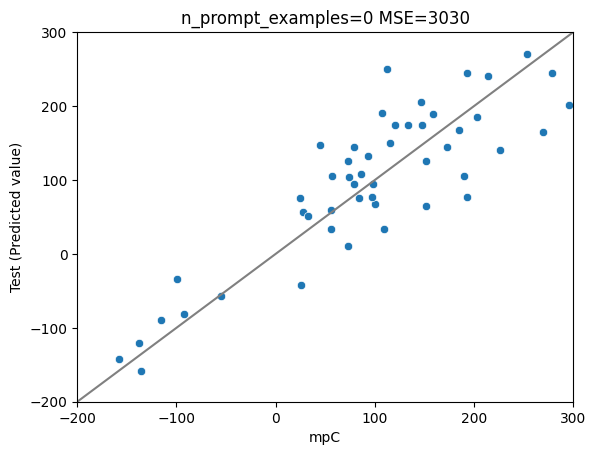

In [22]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model=mixtral_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [23]:
#スコア
print("MSE: ",mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print("MAE: ",mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print("R2: ", r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


MSE:  3030.2451020408166
MAE:  44.699999999999996
R2:  0.7405056695629278


In [24]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.98